In [129]:
# !pip install qiskit qiskit-aer pylatexenc

In [130]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram


In [131]:

# =========================================
# 1. Setup circuit
# =========================================

q_reg = QuantumRegister(3, name="data")
q_reg_ancilla = QuantumRegister(2, name="ancilla")
c_reg = ClassicalRegister(2, name="syndrome")
c_reg_result = ClassicalRegister(1, name="result")

qc = QuantumCircuit(q_reg, q_reg_ancilla, c_reg, c_reg_result)

# ================================
# STEP 2: Initial State
# ================================
u = np.random.uniform(0, 1)
theta = np.arccos(u)
qc.ry(theta, q_reg[0])
Statevector(qc).draw('latex')

<IPython.core.display.Latex object>

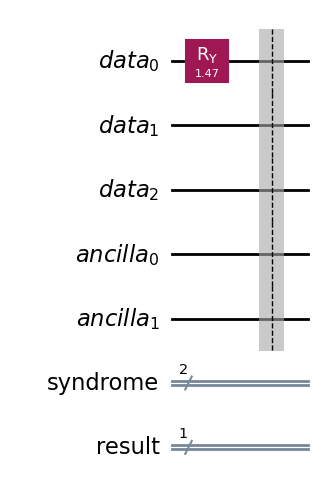

In [132]:

qc.barrier()
qc.draw("mpl")

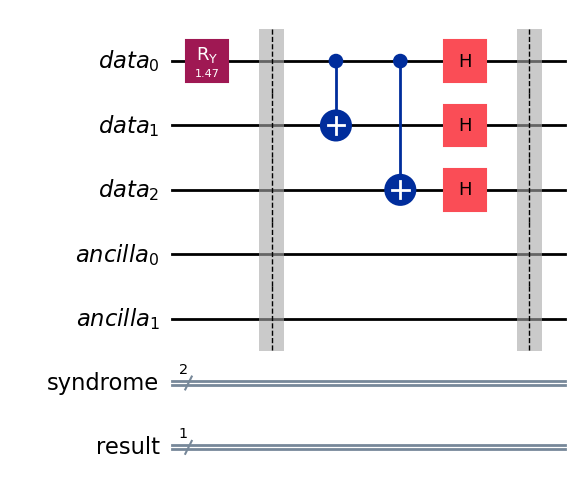

In [133]:

# =========================================
# 3. Encoding (Bit-flip encoding + Hadamard Sandwich)
# =========================================
qc.cx(q_reg[0], q_reg[1])
qc.cx(q_reg[0], q_reg[2])
qc.h(q_reg[0])
qc.h(q_reg[1])
qc.h(q_reg[2])
qc.barrier()
qc.draw("mpl")

Phase Error (Z) injected on Qubit: 2


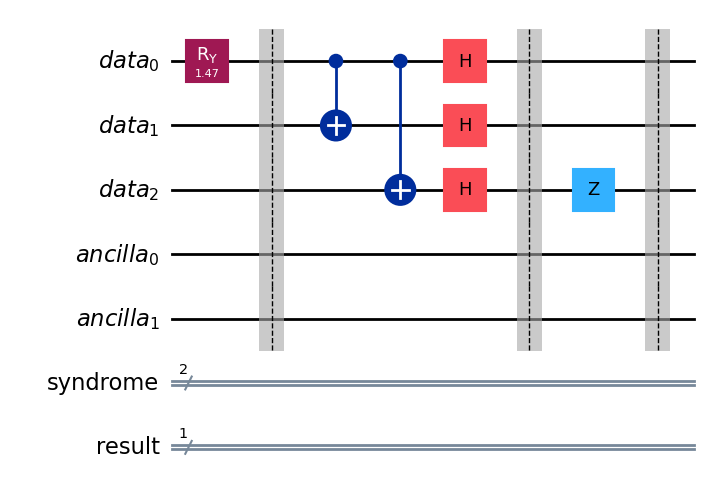

In [134]:

# =========================================
# STEP 4: Error Injection
# =========================================
error_circ = QuantumCircuit(3)
ind = np.random.randint(0, 4)
if ind > 0:
    error_circ.z(ind-1)
    print(f"Phase Error (Z) injected on Qubit: {ind-1}")
else:
    print("No error injected.")

qc.compose(error_circ, q_reg, inplace=True)
qc.barrier()
qc.draw("mpl")

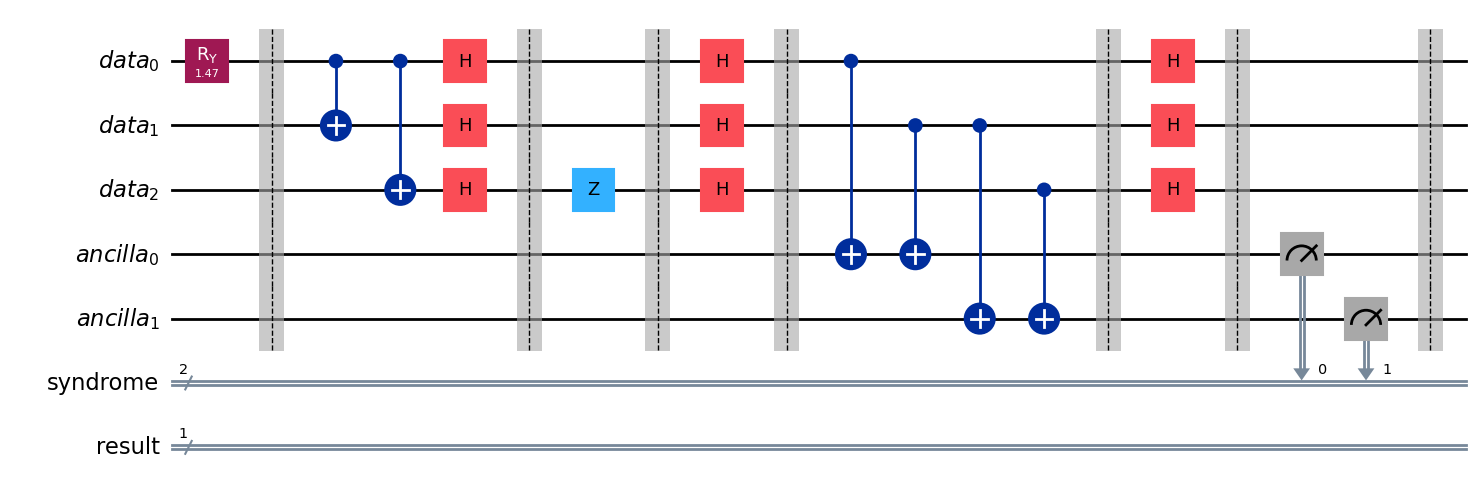

In [135]:

# =========================================
# STEP 5: Syndrome Extraction
# =========================================
qc.h(q_reg)
qc.barrier()

qc.cx(q_reg[0], q_reg_ancilla[0])
qc.cx(q_reg[1], q_reg_ancilla[0])
qc.cx(q_reg[1], q_reg_ancilla[1])
qc.cx(q_reg[2], q_reg_ancilla[1])
qc.barrier()

qc.h(q_reg)
qc.barrier()

qc.measure(q_reg_ancilla[0], c_reg[0])
qc.measure(q_reg_ancilla[1], c_reg[1])
qc.barrier()

qc.draw("mpl")

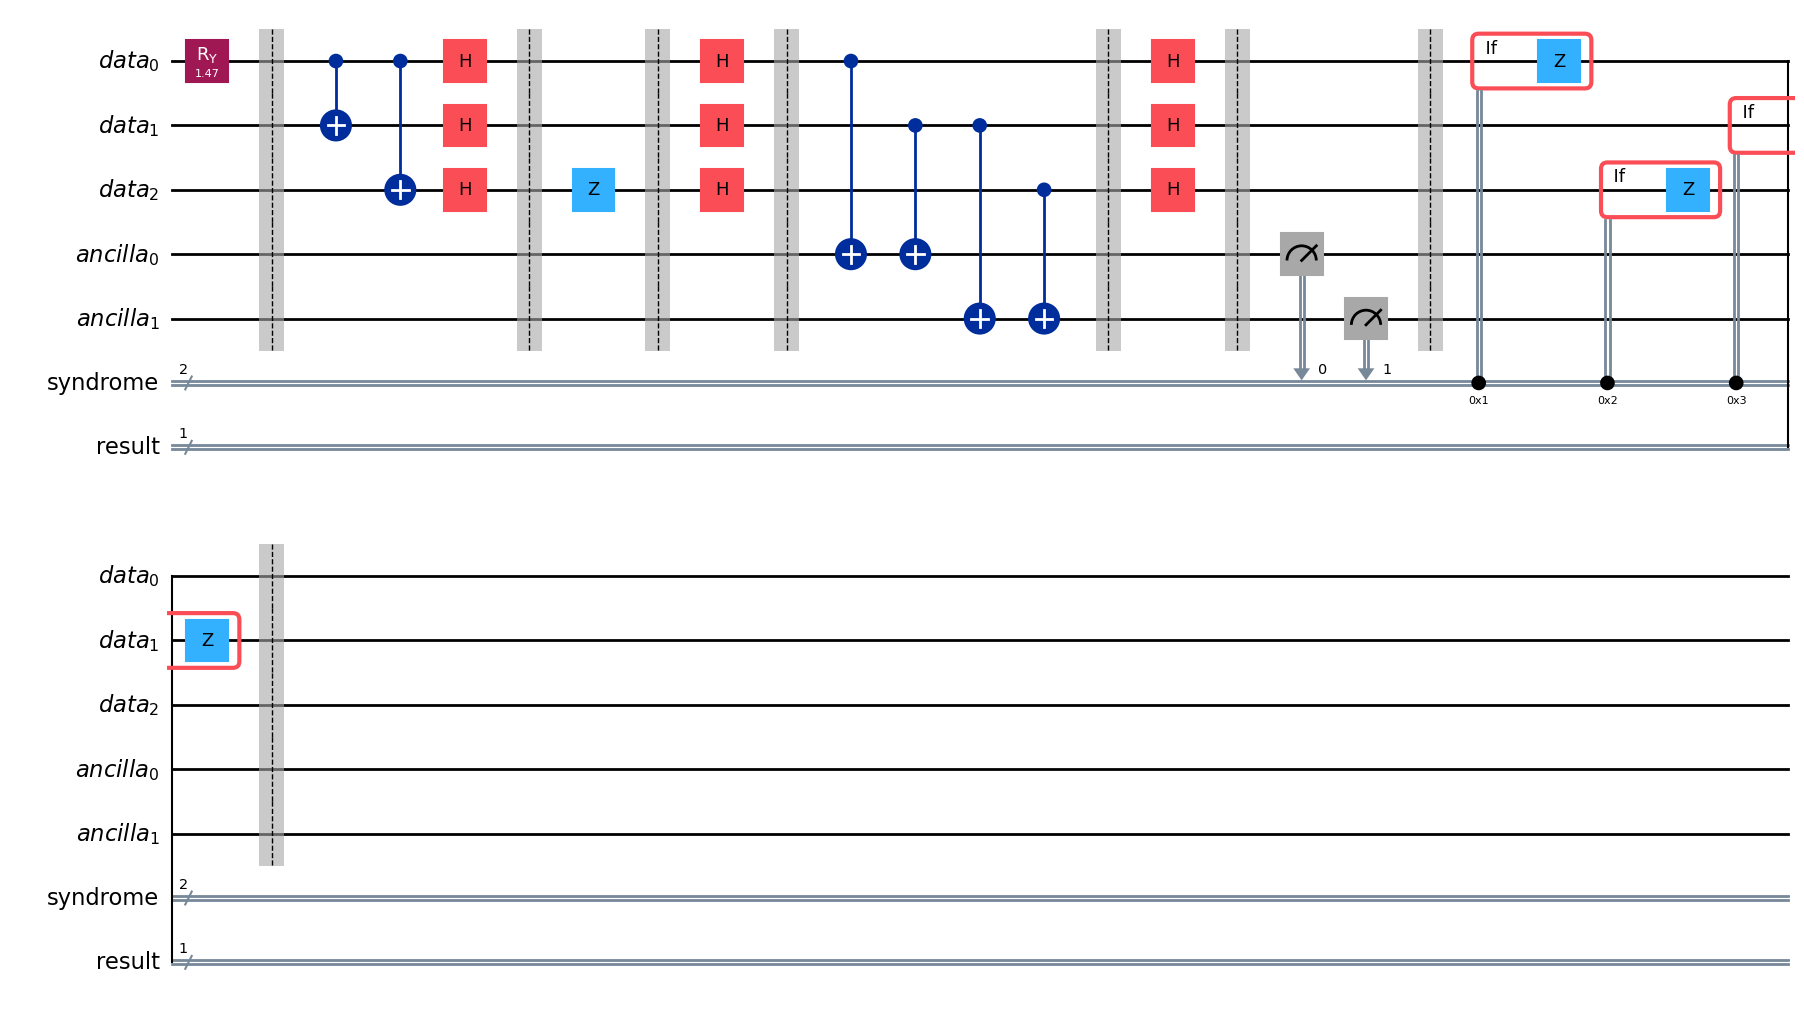

In [136]:

# =========================================
# 6. Decoding
# =========================================
with qc.if_test((c_reg, 1)):
    qc.z(q_reg[0])
with qc.if_test((c_reg, 2)):
    qc.z(q_reg[2])
with qc.if_test((c_reg, 3)):
    qc.z(q_reg[1])
qc.barrier()

qc.draw("mpl")

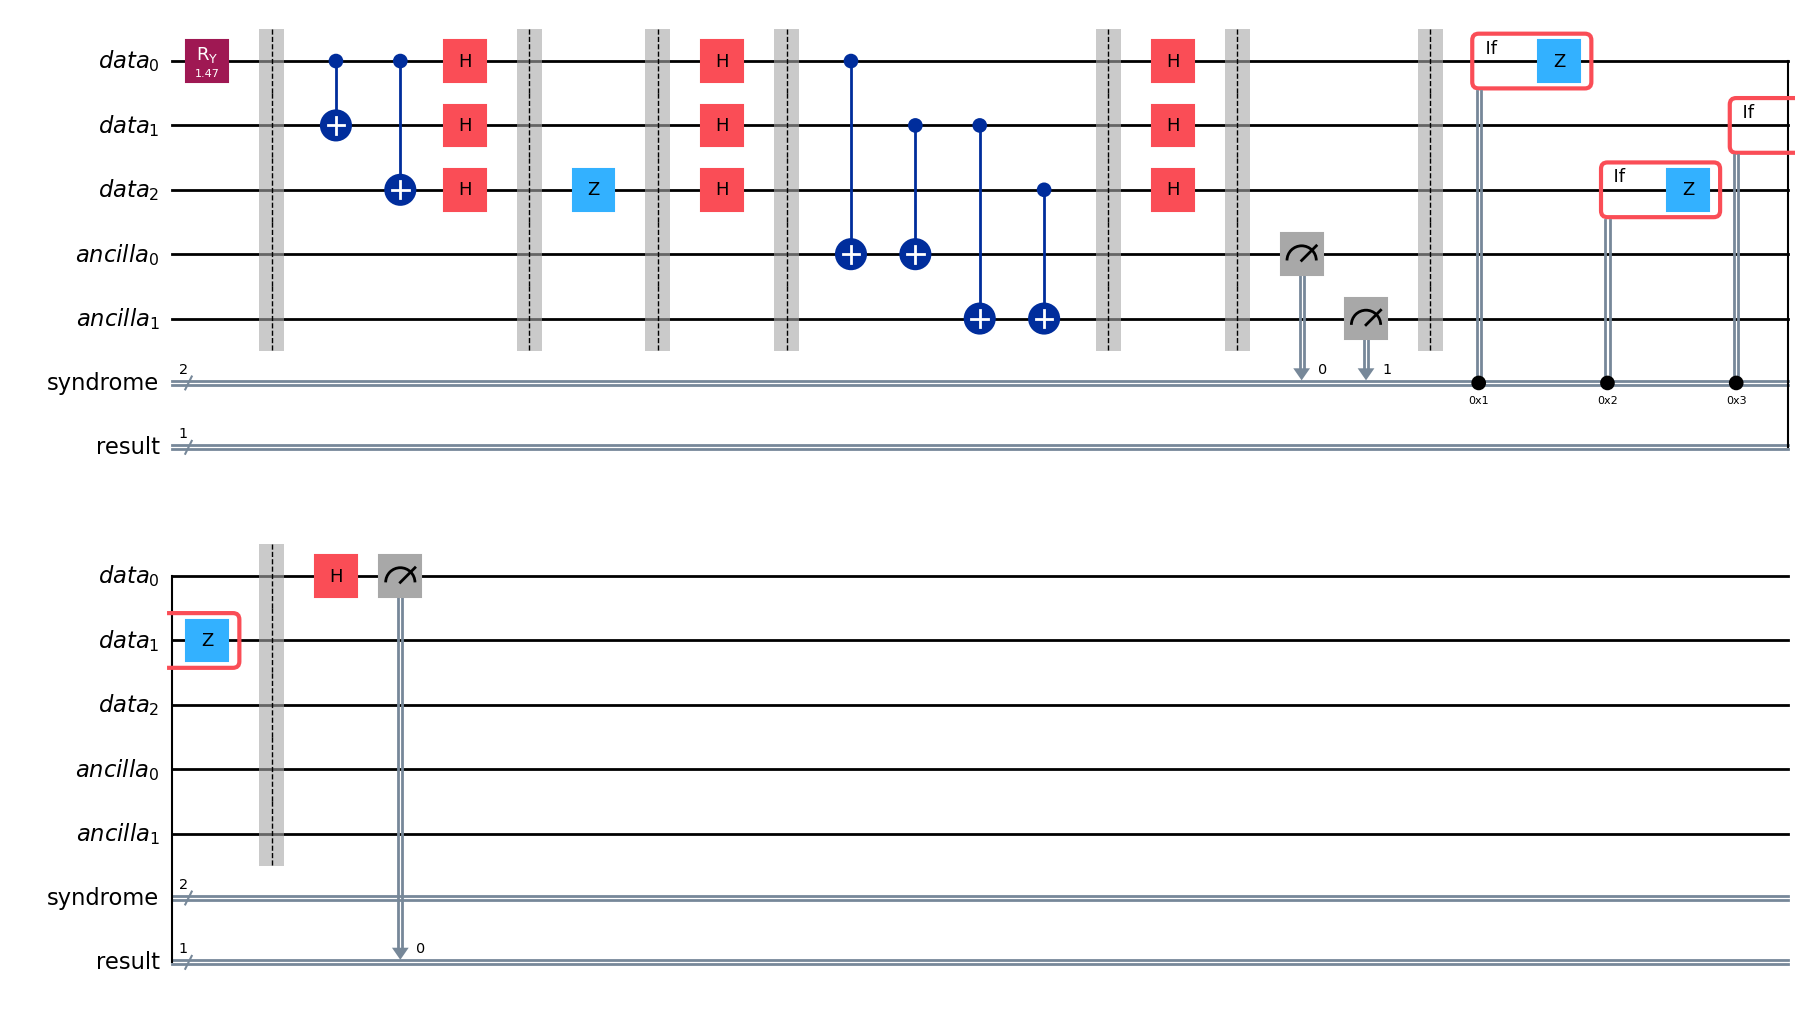

In [137]:

# =========================================
# 7. Final state measurement
# =========================================
qc.h(q_reg[0])
qc.measure(q_reg[0], c_reg_result[0])
qc.draw("mpl")

------------------------------
Theoretical P(0): 0.5493
Experimental P(0): 0.5342
Difference: 0.0152
Syndrome detected: 10
------------------------------


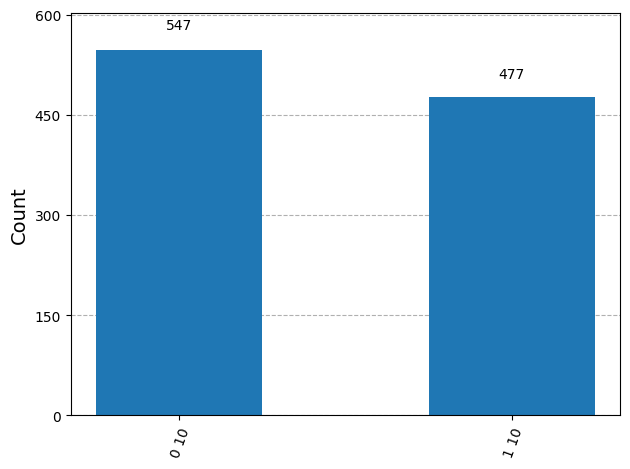

In [138]:

# =========================================
# 8. Execution & Analysis
# =========================================
simulator = AerSimulator()
qc_t = transpile(qc, simulator)
shots = 1024
result = simulator.run(qc_t, shots=shots).result()
counts = result.get_counts()

# Calculate Theoretical vs Experimental
p0_theory = (1 + u) / 2
count_0 = sum(count for key, count in counts.items() if key.split()[0] == '0')
p0_exp = count_0 / shots

print("-" * 30)
print(f"Theoretical P(0): {p0_theory:.4f}")
print(f"Experimental P(0): {p0_exp:.4f}")
print(f"Difference: {abs(p0_theory - p0_exp):.4f}")
print(f"Syndrome detected: {list(counts.keys())[0].split()[1]}")
print("-" * 30)
plot_histogram(counts)